In [1]:
import sqlite3
import pandas as pd
import numpy as np
import os
import geopandas as gpd
import rasterio as rio
from rasterio.plot import show
from scripts.scripts import *
import matplotlib.pyplot as plt
import geosardine as dine

# Validation experiments analysis

In [32]:
#Open the data from the excel sheet

turb = pd.read_excel(os.path.join(os.getcwd(),"data","a3_experiments_2404.xlsx"), engine = "openpyxl",sheet_name  = "TURB")
tds = pd.read_excel(os.path.join(os.getcwd(),"data","a3_experiments_2404.xlsx"), engine = "openpyxl",sheet_name  = "TDS")
ph = pd.read_excel(os.path.join(os.getcwd(),"data","a3_experiments_2404.xlsx"), engine = "openpyxl",sheet_name  = "PH")
temp =  pd.read_excel(os.path.join(os.getcwd(),"data","a3_experiments_2404.xlsx"), engine = "openpyxl",sheet_name  = "TEMP")

In [62]:
# Calibrate the data into usable values, from the calibrated solutions
def calibrate(hi,lo,vhi,vlo, obs):
    m = (hi-lo)/(vhi-vlo)
    val = hi-(vhi-obs)*m
    return val

#For turbidity, rinse and repeat for allthe other ones
t_hi = turb.Meter[3]
t_lo = turb.Meter[0]
tv_hi = turb.Robot[3]
tv_lo = turb.Robot[0]
cal = calibrate(hi = t_hi, lo = t_lo,vhi = tv_hi, vlo = tv_lo, obs = turb.Robot)
turb["Calib"] = cal

# for tds
t_hi = tds.Meter[0]
t_lo = tds.Meter[3]
tv_hi = tds.Robot[0]
tv_lo = tds.Robot[3]
cal = calibrate(hi = t_hi, lo = t_lo,vhi = tv_hi, vlo = tv_lo, obs = tds.Robot)
tds["Calib"] = cal

# for pH
t_hi = ph.Meter[1]
t_lo = ph.Meter[0]
tv_hi = ph.Robot[1]
tv_lo = ph.Robot[0]
cal = calibrate(hi = t_hi, lo = t_lo,vhi = tv_hi, vlo = tv_lo, obs = ph.Robot)
ph["Calib"] = cal



Make a figure from this data, in order to quickly show off the results

<ipython-input-98-22aafd16e212>:62: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


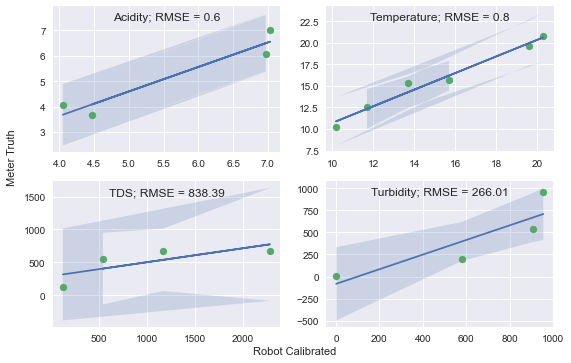

In [98]:
def error_data(x,y):
    import numpy as np
    a, b = np.polyfit(x, y, deg=1)
    y_est = a * x + b
    y_err = x.std() * np.sqrt(1/len(x) +
                              (x - x.mean())**2 / np.sum((x - x.mean())**2))
    
    from sklearn.metrics import mean_squared_error

    rms = mean_squared_error(x, y, squared=False)

    return y_est, y_err,rms

import matplotlib.pyplot as plt

plt.rcParams['text.usetex'] = False
plt.style.use("seaborn")
fig, axs = plt.subplots(nrows = 2, ncols =2)

x = ph.Meter
y= ph.Calib
y_est, y_err,rms = error_data(x,y)
axs[0,0].plot(x, y_est, '-')
axs[0,0].fill_between(x, y_est - y_err, y_est + y_err, alpha=0.2)
axs[0,0].scatter( ph.Meter, ph.Calib)
axs[0,0].set_title(f"Acidity; RMSE = {round(rms,2)}" , y=1.0, pad=-14)



x =temp.Meter
y= temp.Robot
y_est, y_err,rms = error_data(x,y)
axs[0,1].plot(x, y_est, '-')
axs[0,1].fill_between(x, y_est - y_err, y_est + y_err, alpha=0.2)
axs[0,1].scatter( temp.Meter, temp.Robot)
axs[0,1].set_title(f"Temperature; RMSE = {round(rms,2)}", y=1.0, pad=-14)



x = tds.Meter
y= tds.Calib
y_est, y_err,rms = error_data(x,y)
axs[1,0].plot(x, y_est, '-')
axs[1,0].fill_between(x, y_est - y_err, y_est + y_err, alpha=0.2)
axs[1,0].scatter( tds.Meter, tds.Calib)
axs[1,0].set_title(f"TDS; RMSE = {round(rms,2)}", y=1.0, pad=-14)



x = turb.Meter
y= turb.Calib
y_est, y_err,rms = error_data(x,y)
axs[1,1].plot(x, y_est, '-')
axs[1,1].fill_between(x, y_est - y_err, y_est + y_err, alpha=0.2)
axs[1,1].scatter( turb.Meter, turb.Calib)
axs[1,1].set_title(f"Turbidity; RMSE = {round(rms,2)}", y=1.0, pad=-14)

fig.text(0.5, 0.01, 'Robot Calibrated', va='center', ha='center', fontsize=plt.rcParams['axes.labelsize'])
fig.text(0.01, 0.5, 'Meter Truth', va='center', ha='center', rotation='vertical', fontsize=plt.rcParams['axes.labelsize'])

fig.savefig("output/calibration_results.png", dpi=300)
fig.show()


# Interpolation data preparation
From raw ROS2 bags, to usable pandas dataframes

In [9]:
#name of the ROSbag
rosbagname = "test9_April28"

# the bags are found in this zip under data
# directory should point to that

db_loc = os.path.join(os.path.expanduser('~'), "Documents","wqdrone","rosbags",rosbagname,rosbagname+"_0.db3")

#create connection to rosbag
con = sqlite3.connect(db_loc)

#read the topics in the rosbag
topics = pd.read_sql("SELECT * from topics", con)
# read all the msgs in the rosbag
msgs = pd.read_sql("SELECT * from messages", con)

#/topics that you want
t1 = "teensy_fix" 
t2 =  "wq_sensors"

#the above function is called to create df out of the rosbag
df_fix = parse_df(topics,msgs, t1,gps_float64,cols = ["lat", "lon","alt"])
df_wq = parse_df(topics,msgs, t2, wq_float64,cols = ["temp","tds","turb","t_v","ph","ph_v"])


#The data is merged to the closest neighbor, based on timestamp.
df = pd.merge_asof(df_fix,df_wq, on = "timestamp").dropna()
#create gdf to convert WGS84 to UTM
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat), crs = "EPSG:4326")

#select until row n
# n = 150
#df = df[df["timestamp"] < df["timestamp"][n]]

# Creating the extent polygon of the lake
to use in the other analysis as masks and extents

In [111]:
extent = gpd.read_file("data\poly_lumen.geojson")

def getFeatures(gdf):
    """Function to parse features from GeoDataFrame in such a manner that rasterio wants them"""
    import json
    return [json.loads(gdf.to_json())['features'][0]['geometry']]

f = getFeatures(extent)
ext = extent.total_bounds

# Building IDW and Model accuracy

In [233]:
from geosardine.interpolate import idw

#making sure that every run will be the same
import random
random.seed("interpolation")

gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat), crs = "EPSG:4326")
gdf = gdf.iloc[50:-200]
#Test-train splitting
msk = np.random.rand(len(gdf)) < 0.67

train = gdf[msk]
test = gdf[~msk]

#Sample the testing points from the dataset
train_coords = np.array([[x,y] for x, y in zip(train.geometry.x, train.geometry.y)])
test_coords = np.array([(x,y) for x, y in zip(test.geometry.x, test.geometry.y)])
val = np.array(train["temp"])


temp_idw = idw(train_coords,
               val,
              spatial_res = (0.00001,0.00002),
              epsg = 4326,
            extent = ext,
              )

location = "data/temp_idw.tif"

temp_idw.save(location)


#Add the mask
src = rio.open(location)
out_image, out_transform = rio.mask.mask(src, f, crop=False)
out_meta = src.meta
out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
               "nodata": 0,
                    })

with rio.open("data/temp_idw_masked.tif", "w", **out_meta) as dest:
    dest.write(out_image)

data/temp_idw.tif saved


<AxesSubplot:>

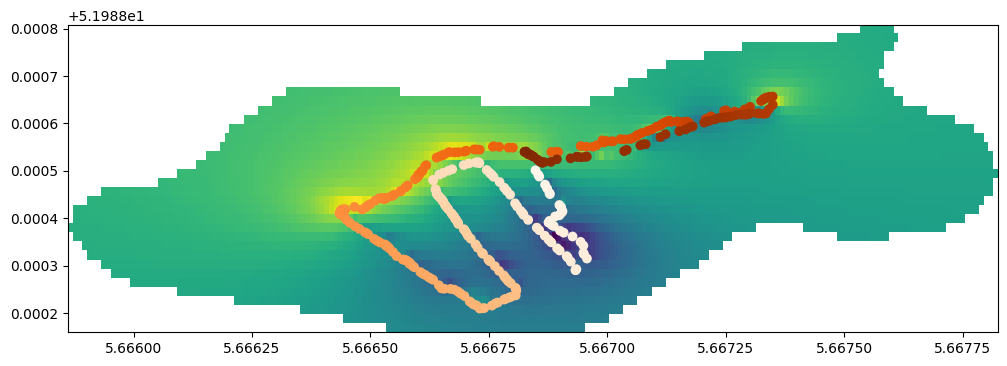

In [234]:
#quick viz of it all!
import matplotlib.pyplot as plt
from rasterio.plot import show

src = rio.open("data/temp_idw_masked.tif")
plt.style.use("default")
fig, ax = plt.subplots(figsize=(12,12))

test.plot(ax=ax, c= test["temp"], cmap = "Oranges")
show(src, ax=ax, cmap = "viridis")


# Building Kriging and Model accuracy

Let's run the krigin with proper train/test/val splitting, cross validation and accuracy measurements. To find the best model for this application.


In [37]:
#making sure that every run will be the same
import random
random.seed("interpolation")

#Test-train splitting
msk = np.random.rand(len(df)) < 0.67
train = df[msk]
test = df[~msk]

#Run the interpolation model and save it as a raster
z,SS,gridx,gridy = interkrige(train.lon,
                              train.lat,
                              train.temp,
                              res = 100,
                             model = "linear")
#also add cutout mask phaps?
location = rasterbuilder(z,gridx,gridy, "train_temperature")

src = rio.open(location)

In [38]:
#create a geopandas df from the test-data
import geopandas as gpd
g_test = gpd.GeoDataFrame(test, geometry=gpd.points_from_xy(test.lon, test.lat), crs = "EPSG:4326")

#Sample the testing points from the dataset
coords = [(x,y) for x, y in zip(g_test.geometry.x, g_test.geometry.y)]
g_test['interpol_temp'] = [x[0] for x in src.sample(coords)]
# remove zeros from outside the box sampling
g_test = g_test[g_test['interpol_temp'] != 0]



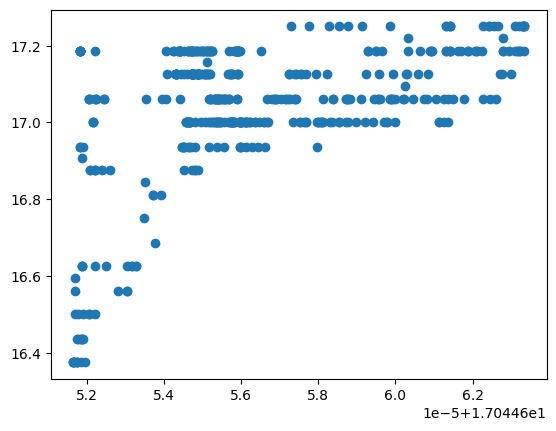

In [39]:
import matplotlib.pyplot as plt

plt.scatter(y = g_test.temp,x = g_test.interpol_temp)


<AxesSubplot:>

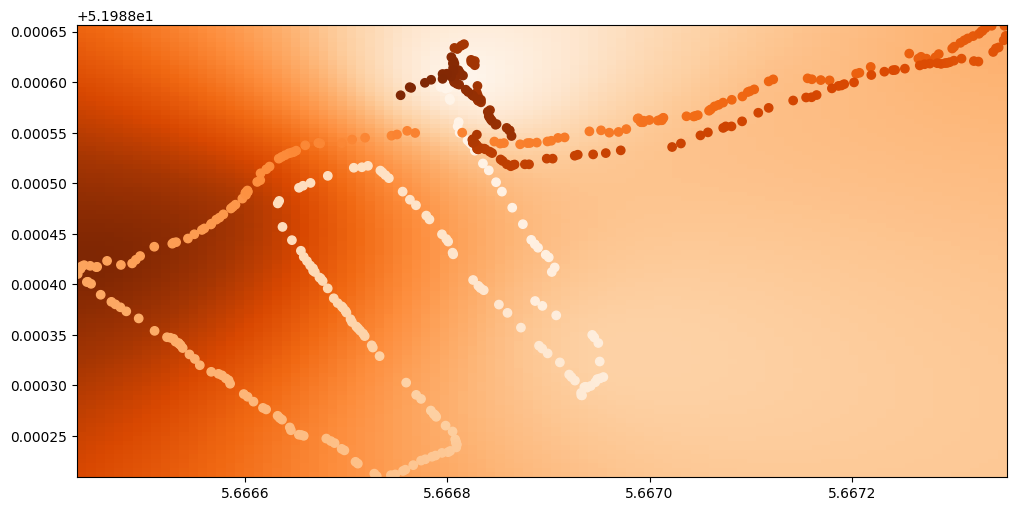

In [40]:
#visualize it all!
import matplotlib.pyplot as plt
from rasterio.plot import show
plt.style.use("default")
fig, ax = plt.subplots(figsize=(12,12))
g_test.plot(ax=ax, c= g_test["temp"], cmap = "Oranges")
show(src, ax=ax, cmap = "Oranges")